<div style="float:left;font-size:20px;">
    <h1>Solar Panel Classification</h1>
</div><div style="float:right;"><img src="../assets/banner.jpg"></div>

Data:
- Shape = (180, 180, 4) -> (180, 180, 3) by removing alpha
- Features = 97200
- Metrics: 35 epochs ~ 0.9948 (Expect ~ 0.95 given data distribution)

<hr>

Todo:
- Data augmentation
- Dropout
- Learning rate schedules
- TensorBoard

Ideas:
- Hypyeropt/Hyperas for hyperparameter optimisation
- Combat overfitting
    - Feature enrichment: Squares, blue/white boundaries
    - Rotations and scale transforms to enrich dataset
- Image denoising and smoothing
- Pretrained models and transfer learning
- Compression via PCA dimensionality reduction or clustering
- Compression via greyscale/reducing resolution

In [1]:
data_dir = 'V:/MachineLearning/SolarPanelClassification/tagging1/'
nosolar_dir = data_dir + 'no_solar/'
solar_dir = data_dir + 'contains_solar/'
IMG_HEIGHT = 180
IMG_WIDTH = 180
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
image_batch_size = 2843    # Number of images to load
classes = ['contains_Solar', 'no_solar']

import numpy as np
np.random.seed(42)

In [2]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           # Data augmentation
                                           horizontal_flip=True,
                                           #rotation_range=45,
                                           #zoom_range=0.5,
                                          )
train_data_gen = train_image_generator.flow_from_directory(batch_size=image_batch_size,
                                                           directory=data_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           classes=classes,
                                                           class_mode='binary')

Found 2843 images belonging to 2 classes.


In [3]:
X, y = next(train_data_gen)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Data distribution

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.hist(y, bins=[0, 0.5, 1]);
plt.xlabel('Class')
plt.ylabel('Frequency');

The dataset is very imbalanced, which may lead to a bias during training. We can tackle this in several ways such as under and over sampling. We will attempt to correct this using `class_weights` during the fit.

In [6]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(y_train), 
            y_train)

The solar class will have a weight of 9.35 and the no solar a weight of 0.53

In [7]:
class_weights

array([9.51785714, 0.52772277])

### Oversampling

Alternatively we can oversample the `solar` class to match the other.

In [8]:
X_solar = X[y == 0.]
X_nosolar = X[y != 0.]

y_solar = y[y == 0.]
y_nosolar = y[y != 0.]

ids = np.arange(len(X_solar))
choices = np.random.choice(ids, len(X_nosolar))

# Perform oversampling
X_solar_os = X_solar[choices]
y_solar_os = y_solar[choices]

X_os = np.concatenate([X_solar_os, X_nosolar], axis=0)
y_os = np.concatenate([y_solar_os, y_nosolar], axis=0)
X_train_os, X_test_os, y_train_os, y_test_s = train_test_split(X_os, y_os)

Now the classes are balanced

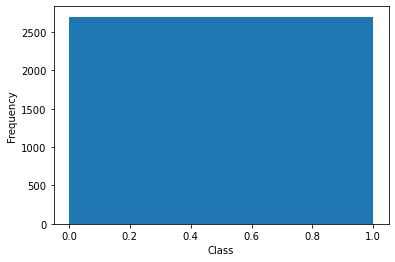

In [9]:
fig, ax = plt.subplots()
plt.hist(y_os, bins=[0, 0.5, 1]);
plt.xlabel('Class')
plt.ylabel('Frequency');

## Visualisation

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
len(X)

2843

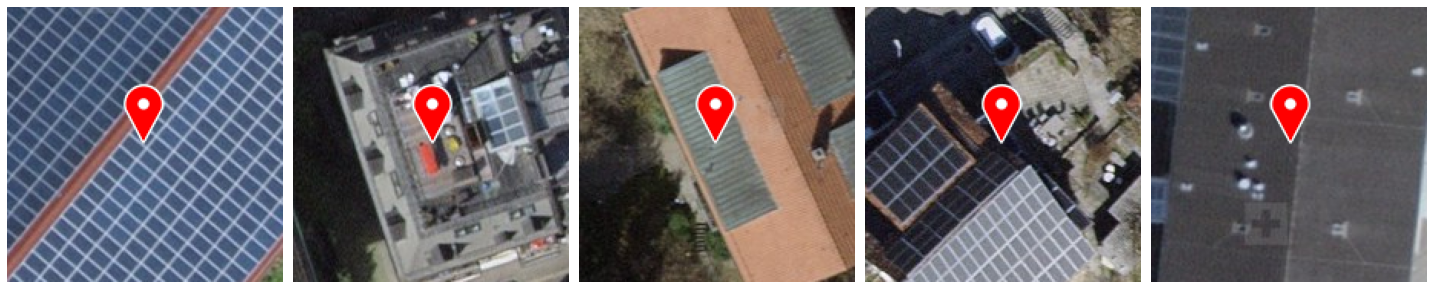

In [12]:
plotImages(X[:5])

In [159]:
X.shape

(2843, 180, 180, 3)

In [160]:
y

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

5.1% of datasets have solar panels
-> Expect the "No solar panel" model to have an accuracy of 94.9%

In [161]:
import numpy as np
np.mean(y_train), np.mean(y_test)

(0.94746715, 0.95499295)

## Base CNN models

In [13]:
# ReLU activation functions are better initialised by Glorot-Xavier-uniform (this is default anyway)
kernel_initializer = 'glorot_uniform'

In [14]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Class reweighting: 10 epochs - 6ms/sample - loss: 7.3525e-04 - get_f1: 0.9722 - val_loss: 0.4776 - val_get_f1: 0.9785
# Oversampling     : 6 epochs  - 6ms/sample - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0342 - val_acc: 0.9916
model = models.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=kernel_initializer,
           input_shape=input_shape),
    layers.MaxPooling2D(),
    #layers.Dropout(0.2),
    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_initializer=kernel_initializer,),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 7, padding='same', activation='relu', kernel_initializer=kernel_initializer,),
    layers.MaxPooling2D(),
    #layers.Dropout(0.2),
    layers.Flatten(),
    #layers.Dense(512, activation='relu', kernel_initializer=kernel_initializer),
    #layers.Dense(2, activation='softmax')
    layers.Dense(1)
])

# Class reweighting: 10 epochs - 7ms/sample - loss: 8.6376e-04 - get_f1: 0.9718 - val_loss: 0.4732 - val_get_f1: 0.9794
# Oversampling     : 10 epochs - 6ms/sample - loss: 0.0070 - acc: 0.9995 - val_loss: 0.0098 - val_acc: 0.9972
lenet_5_model = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), strides=1,  activation='relu', kernel_initializer=kernel_initializer,
                  input_shape=input_shape, padding='same'), #C1
    layers.AveragePooling2D(pool_size=(2, 2), strides=2), #S2
    layers.Conv2D(16, kernel_size=(5, 5), strides=1, activation='relu', kernel_initializer=kernel_initializer,
                  padding='valid'), #C3
    layers.AveragePooling2D(pool_size=(2, 2), strides=2), #S4
    layers.Flatten(), #Flatten
    layers.Dense(120, activation='relu', kernel_initializer=kernel_initializer), #C5
    layers.Dense(84, activation='relu', kernel_initializer=kernel_initializer), #F6
    layers.Dense(2, activation='softmax')  # Output layer
])

# Class reweighting: 10 epochs - 40ms/sample - loss: 0.2072 - get_f1: 0.9703 - val_loss: 0.1724 - val_get_f1: 0.9785
# Oversampling     : 10 epochs - 38ms/sample - loss: 0.0342 - acc: 0.9933 - val_loss: 0.0185 - val_acc: 0.9944
# Incredibly slow
cnn_conv_pool = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_initializer,
                  input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_initializer,),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_initializer,),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_initializer=kernel_initializer),
    layers.Dense(2, activation='softmax')
])

# Class reweighting: 10 epochs - 28ms/sample - loss: 0.2129 - get_f1: 0.9732 - val_loss: 0.1788 - val_get_f1: 0.9791
# Oversampling     : 10 epochs - 27ms/sample - loss: 2.8903e-04 - acc: 1.0000 - val_loss: 0.0292 - val_acc: 0.9944
# Also slow
cnn_vgg = models.Sequential([
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_initializer,
                  padding='same',input_shape=input_shape),
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_initializer,
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_initializer,),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=kernel_initializer,),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_initializer=kernel_initializer),
    layers.Dense(2, activation='softmax')
])


### Model selection

In [15]:
#model = model
model = lenet_5_model
#model = cnn_conv_pool
#model = cnn_vgg

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 180, 180, 8)       224       
_________________________________________________________________
average_pooling2d (AveragePo (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 86, 86, 16)        3216      
_________________________________________________________________
average_pooling2d_1 (Average (None, 43, 43, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 29584)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               3550200   
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [166]:
#tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

### Optimiser

In [17]:
# Learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

#optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,)

## Train the model

As the dataset is imbalanced, we will use the F1 score for computing the loss function to avoid bias.

In [18]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [20]:
metric = 'f1'
metric = 'auc'
metric = 'acc'

In [21]:
epochs = 20

Class reweighting appears to have difficulty in training, oversampling is much more successful.

In [ ]:
#score_output = layers.Dense(1, name="score_output")(x)
#class_output = layers.Dense(2, activation="softmax", name="class_output")(x)

tf.random.set_seed(42)

model.compile(optimizer=optimizer,
              #loss='binary_crossentropy',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],  # The dataset is imbalanced so this is biased
              #metrics=[f1],
              #outputs=[score_output, class_output]
             )

history = model.fit(#X_train, y_train,   # Train with imbalanced data
                    #class_weight=class_weights, # Only use with imbalanced data
                    X_train_os, y_train_os,     # Use oversampling
                    batch_size=256, epochs=epochs, 
                    #validation_split=0.2,
                    validation_data=(X_test, y_test),
                    shuffle=True)

Epoch 1/20
16/16 [==============================] - 22s 1s/step - loss: 0.7625 - accuracy: 0.5516 - val_loss: 0.7272 - val_accuracy: 0.2700
Epoch 2/20
16/16 [==============================] - 22s 1s/step - loss: 0.5968 - accuracy: 0.7001 - val_loss: 0.7483 - val_accuracy: 0.5893
Epoch 3/20
16/16 [==============================] - 22s 1s/step - loss: 0.4801 - accuracy: 0.7695 - val_loss: 0.3449 - val_accuracy: 0.8875
Epoch 4/20
16/16 [==============================] - 22s 1s/step - loss: 0.3464 - accuracy: 0.8651 - val_loss: 0.4332 - val_accuracy: 0.8228
Epoch 5/20
16/16 [==============================] - 22s 1s/step - loss: 0.2434 - accuracy: 0.9209 - val_loss: 0.0896 - val_accuracy: 0.9831
Epoch 6/20
16/16 [==============================] - 22s 1s/step - loss: 0.1629 - accuracy: 0.9536 - val_loss: 0.0826 - val_accuracy: 0.9831
Epoch 7/20
16/16 [==============================] - 22s 1s/step - loss: 0.0942 - accuracy: 0.9778 - val_loss: 0.0539 - val_accuracy: 0.9873
Epoch 8/20
16/16 [==

711/711 - 2s - loss: 0.0207 - acc: 0.9944


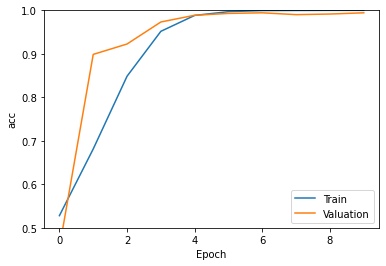

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history[f'{metric}'], label='Train')
plt.plot(history.history[f'val_{metric}'], label = 'Valuation')
plt.xlabel('Epoch')
plt.ylabel(metric)
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [27]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

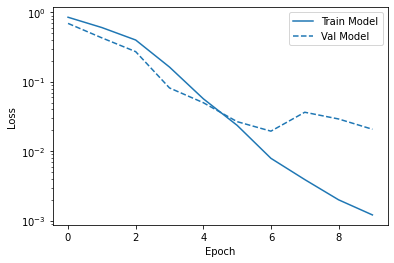

In [28]:
plot_loss(history, "Model", 0)

In [29]:
print(f'Accuracy = {test_acc:.2f}, Loss = {test_loss:.2f}')

Accuracy = 0.99, Loss = 0.02


## Visualising CNN filters

There is are 3x3 and 5x5 filters:

In [31]:
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_3 (3, 3, 3, 8)
conv2d_4 (5, 5, 8, 16)


Visualising filters, White are highly weighted, black are low-weighted.

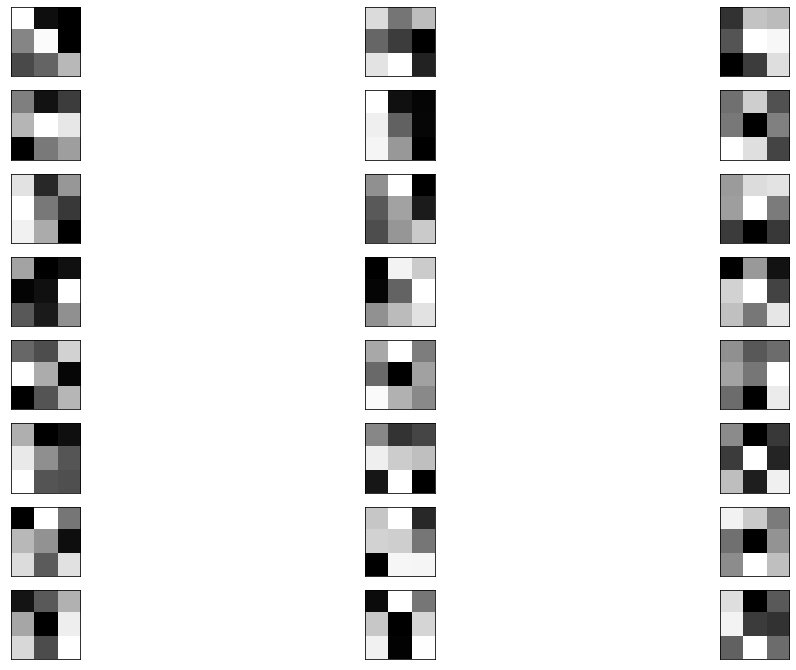

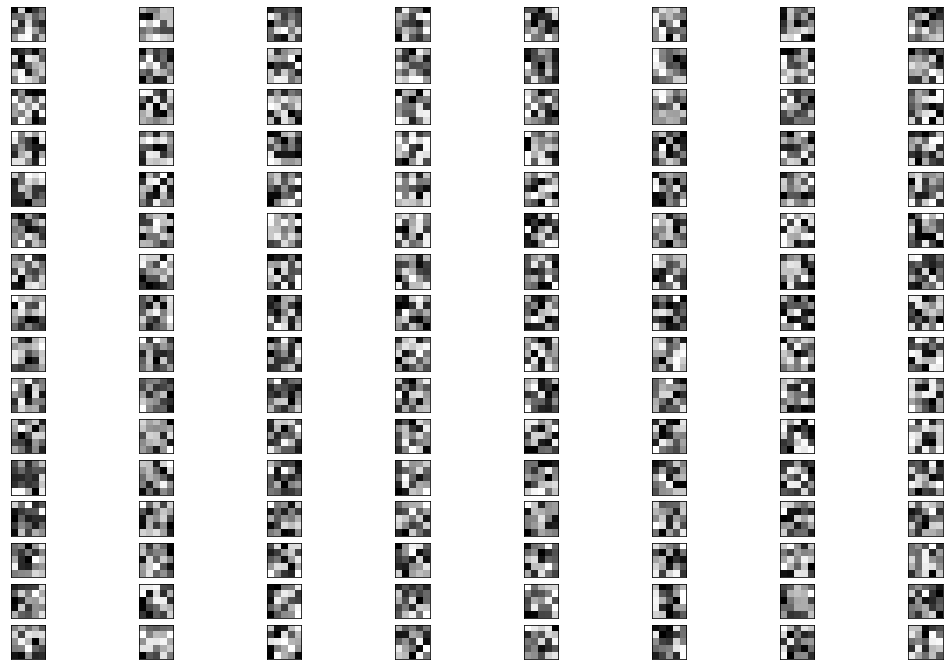

In [48]:
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
        
    # get filter weights
    filters, biases = layer.get_weights()
    #print(layer.name, filters)
    
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    # plot first few filters
    n_filters, ix = 8, 1
    n_filters_x = 3
    if layer.name == 'conv2d_4':
        n_filters = 16
        n_filters_x = 8
        
    fig = plt.figure(figsize=(18, 12))
    for i in range(n_filters):
        # get the filter
        f = filters[:, :, :, i]
        # plot each channel separately
        for j in range(n_filters_x):
            # specify subplot and turn of axis
            ax = plt.subplot(n_filters, n_filters_x, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1
    # show the figure
    plt.show()

## Visualising CNN feature map after first and second CNN and pooling layers

In [115]:
# Create a model that outputs after the first convolution and pooling layers
model_visualise_cnn1 = models.Model(inputs=model.inputs, outputs=model.layers[1].output)
model_visualise_cnn1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 8)       224       
_________________________________________________________________
average_pooling2d (AveragePo (None, 90, 90, 8)         0         
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [136]:
# Create a model that outputs after the first convolution and pooling layers
model_visualise_cnn2 = models.Model(inputs=model.inputs, outputs=model.layers[3].output)
model_visualise_cnn2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 8)       224       
_________________________________________________________________
average_pooling2d (AveragePo (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 86, 86, 16)        3216      
_________________________________________________________________
average_pooling2d_1 (Average (None, 43, 43, 16)        0         
Total params: 3,440
Trainable params: 3,440
Non-trainable params: 0
_________________________________________________________________


In [76]:
feature_maps = model_visualise_cnn1.predict(X[:1], batch_size=64, verbose=1)

1/1 [==============================] - 0s 12ms/sample


In [138]:
def plot_feature_map_cnn1(X, i, model):
    """Plots the feature map from the first cnn layer after pooling
    
        X: Image array
        i: Index of image to plot
        model: Model with output after first CNN layer
    """
    feature_maps = model.predict(X[i:i+1], batch_size=64)
    fig = plt.figure(figsize=(18, 12))
    
    n_features = 8
    square = 3
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            if ix > n_features:
                plt.imshow(X[i])
                break
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1

    plt.tight_layout()

In [139]:
def plot_feature_map_cnn2(X, i, model):
    """Plots the feature map from the second cnn layer after pooling
    
        X: Image array
        i: Index of image to plot
        model: Model with output after second CNN layer
    """
    feature_maps = model.predict(X[i:i+1], batch_size=64)
    fig = plt.figure(figsize=(18, 12))
    
    n_features = 16
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1

    plt.tight_layout()

### Image 0: Signal

The first layer picks out edges in the image. The final image appears to only have the pointer.

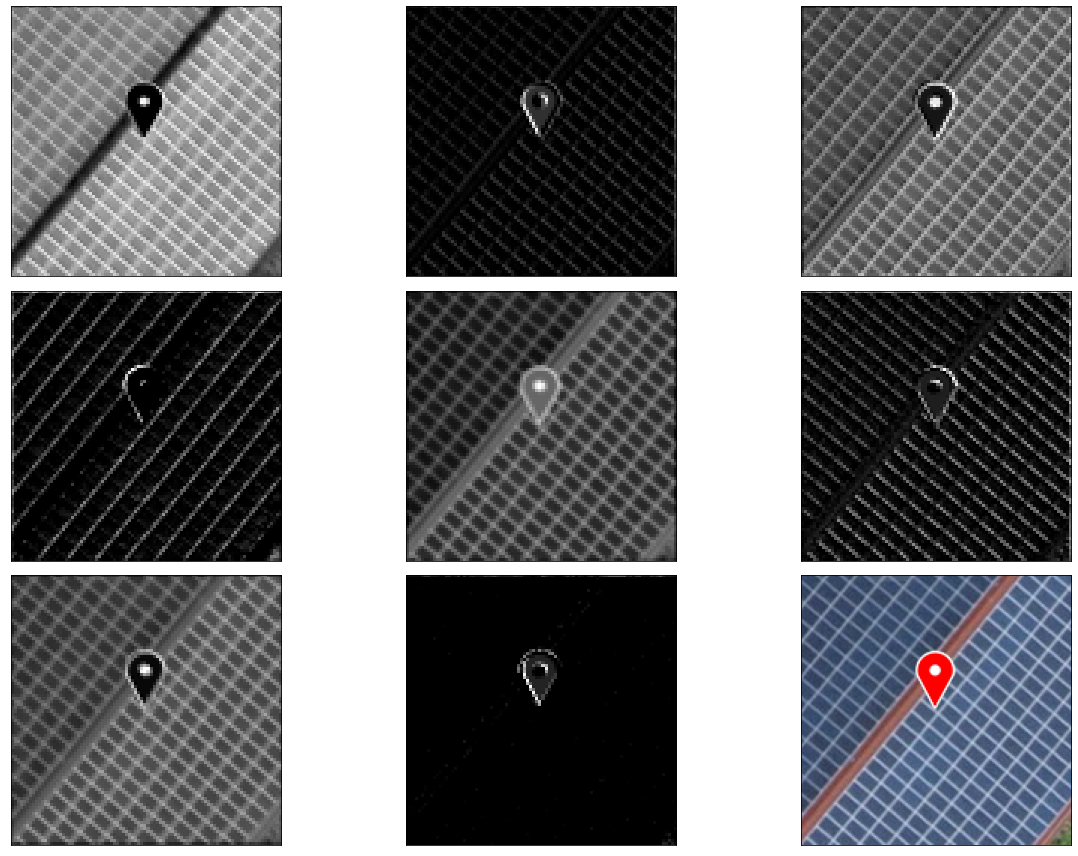

In [140]:
plot_feature_map_cnn1(X, 0, model_visualise_cnn1)

The second CNN appears to perform edge detection in several different directions. Four feature maps appear to be empty, one appears to only have the pointer.

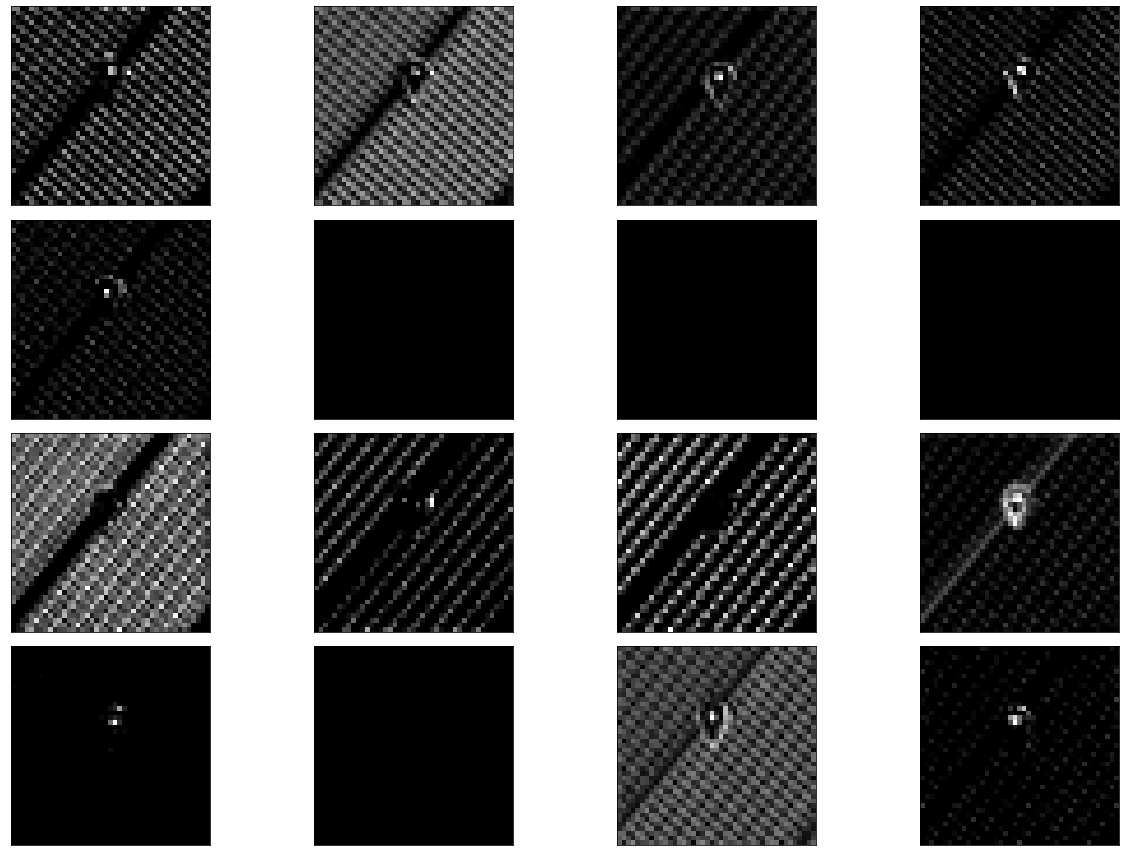

In [141]:
plot_feature_map_cnn2(X, 0, model_visualise_cnn2)

### Image 1500: Background

Background appears to be much brighter than the signal image.

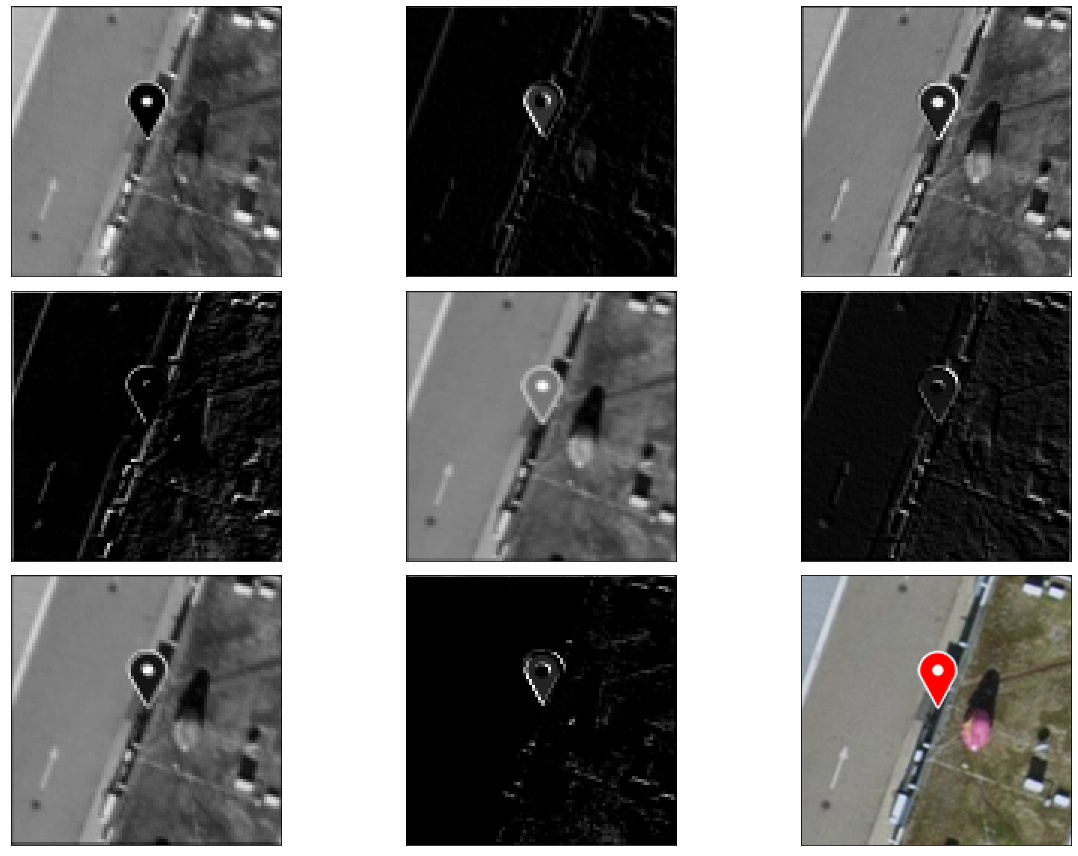

In [143]:
plot_feature_map_cnn1(X, 1500, model_visualise_cnn1)

Again the filters appear to be performing an edge detection. The same four feature maps appear to be blank.m

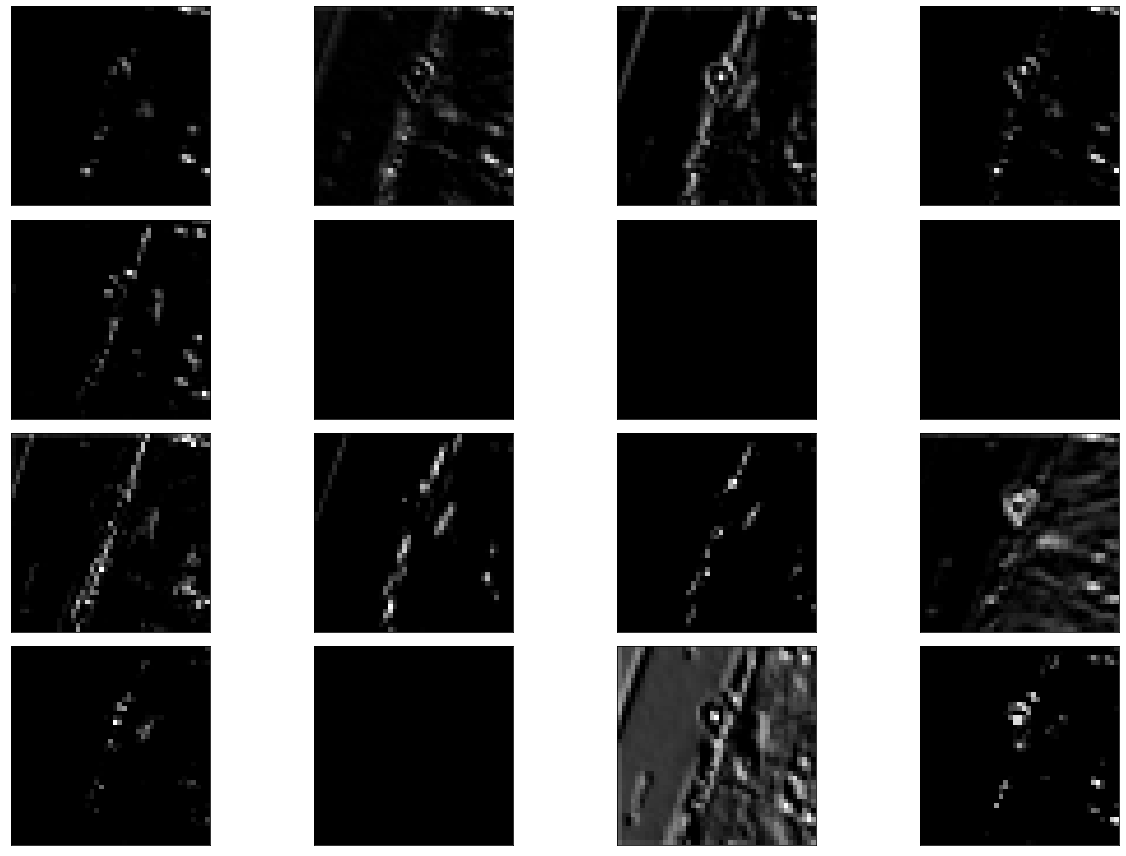

In [144]:
plot_feature_map_cnn2(X, 1500, model_visualise_cnn2)

## Metrics

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

In [58]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool)) #, labels=labels))

711/711 [==============================] - 2s 2ms/sample
              precision    recall  f1-score   support

         0.0       0.20      0.07      0.10        30
         1.0       0.96      0.99      0.97       681

    accuracy                           0.95       711
   macro avg       0.58      0.53      0.54       711
weighted avg       0.93      0.95      0.94       711



In [183]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_bool)

array([[675,   0],
       [ 36,   0]], dtype=int64)

# TO ADD

### Reading
https://www.tensorflow.org/guide/keras/train_and_evaluate

In [ ]:
# Learning rate scheduler
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [ ]:
# TensorBoard
# Run this first: tensorboard --logdir=/full_path_to_your_logs
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

## MNIST classification

In [1]:
import tensorflow as tf
num_classes = 10
img_rows, img_cols = 28, 28
num_channels = 1
input_shape = (img_rows, img_cols, num_channels)
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

C:\Users\Mark\.conda\envs\CatAna\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
# cd /d R:\Projects\JupyterNotebooks\Analysis\Graph
# tensorboard --logdir=R:\Projects\JupyterNotebooks\Analysis\Graph\

In [2]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [] #[tf.keras.callbacks.TensorBoard('./keras')]
model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 5s 75us/sample - loss: 0.6517 - acc: 0.8371 - val_loss: 0.3587 - val_acc: 0.9054
Epoch 2/25
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3379 - acc: 0.9057 - val_loss: 0.2934 - val_acc: 0.9189
Epoch 3/25
60000/60000 [==============================] - 4s 68us/sample - loss: 0.2892 - acc: 0.9192 - val_loss: 0.2609 - val_acc: 0.9282
Epoch 4/25
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2583 - acc: 0.9276 - val_loss: 0.2389 - val_acc: 0.9317
Epoch 5/25
60000/60000 [==============================] - 4s 70us/sample - loss: 0.2351 - acc: 0.9342 - val_loss: 0.2194 - val_acc: 0.9379
Epoch 6/25
60000/60000 [==============================] - 4s 67us/sample - loss: 0.2165 - acc: 0.9395 - val_loss: 0.2056 - val_acc: 0.9418
Epoch 7/25
60000/60000 [===========

## Evaluate performance

In [ ]:

# --------------------------------
# Confusion matrix
# --------------------------------
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
"""
array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)
"""

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)
"""
precision = 0.769 => 76.9% of all positive predictions were correct
recall = 0.801    => 80.1% of all true positives were predicted
"""
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
"""
F1 score = 0.785
"""


# --------------------------------
# Measure Precision and Recall
# --------------------------------
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
save_fig("precision_recall_vs_threshold_plot")
plt.show()


def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()


# --------------------------------
# ROC curves
# --------------------------------
# Receiver operating characteristic

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

# Compute Area Under Curve (AUC) score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
"""
AUC = 0.9624496555967156
"""